![title](http://www.sas.com/content/sascom/en_us/software/viya/_jcr_content/par/styledcontainer_95fa/par/image_e693.img.png/1473452935247.png)

# A Simple Pipeline using Hypergroup to Perform Community Detection and Network Analysis

The study of social networks has gained importance in recent years within social and behavioral research on HIV and AIDS. Social network research offers a means to map routes of potential viral transfer, to analyze the influence of peer norms and practices on the risk behaviors of individuals. This example analyzes the results of a study of high-risk drug use for HIV prevention in Hartford, Connecticut. This social network collected on drug users has 194 nodes and 273 edges.

## Data Preparation
### Import Packages:   SAS Wrapper for Analytic Transfer (SWAT) and Open Source Libraries

In [1]:
import swat
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Also import networkx used for rendering a network
import networkx as nx

%matplotlib inline

### Connect to Cloud Analytic Services in SAS Viya

In [2]:
s = swat.CAS('http://viya.mycompany.com:8777') # REST API

### Load the Action Set for Hypergroup

In [3]:
s.loadactionset('hypergroup')

NOTE: Added action set 'hypergroup'.


[actionset]

 'hypergroup'

+ Elapsed: 0.0192s, user: 0.019s, mem: 0.292mb

In [4]:
drug_network = pd.read_csv('drug_network.csv')

**Hypergroup** doesn't support numeric source and target columns - so make sure to cast them as varchars.

In [5]:
drug_network['SOURCE'] = drug_network['FROM'].astype(str)
drug_network['TARGET'] = drug_network['TO'].astype(str)
drug_network.head()

,FROM,TO,SOURCE,TARGET
0,1,2,1,2
1,1,9,1,9
2,1,10,1,10
3,2,9,2,9
4,2,10,2,10


In [6]:
if s.tableexists('drug_network').exists:
    s.CASTable('drug_network').droptable()
    
dataset = s.upload_frame(drug_network, 
                         importoptions=dict(vars=[dict(type='double'),
                                                  dict(type='double'),
                                                  dict(type='varchar'),
                                                  dict(type='varchar')]),
                          casout=dict(name='drug_network', promote=True))

NOTE: Cloud Analytic Services dropped table drug_network from caslib CASUSER(kesmit).
NOTE: Cloud Analytic Services made the uploaded file available as table DRUG_NETWORK in caslib CASUSER(kesmit).
NOTE: The table DRUG_NETWORK has been created in caslib CASUSER(kesmit) from binary data uploaded to Cloud Analytic Services.


## Data Exploration

### Get to Know Your Data (What are the Variables?)

In [7]:
dataset.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,FROM,1,double,8,12,0,0
1,TO,2,double,8,12,0,0
2,SOURCE,3,varchar,3,3,0,0
3,TARGET,4,varchar,3,3,0,0


In [8]:
dataset.head()

,FROM,TO,SOURCE,TARGET
0,1.0,2.0,1,2
1,1.0,9.0,1,9
2,1.0,10.0,1,10
3,2.0,9.0,2,9
4,2.0,10.0,2,10


In [9]:
dataset.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,FROM,1.0,192.0,273.0,0.0,59.772894,16318.0,42.287875,2.559379,1788.264410,1461782.0,486407.919414,70.747579,23.354455,6.016958e-67
1,TO,2.0,193.0,273.0,0.0,107.802198,29430.0,50.100609,3.032227,2510.071025,3855358.0,682739.318681,46.474571,35.552155,3.020696e-104


### Graph Rendering Utility

In [10]:
def renderNetworkGraph(filterCommunity=-1, size=18, sizeVar='_HypGrp_',
                       colorVar='', sizeMultipler=500, nodes_table='nodes',
                       edges_table='edges'):
    ''' Build an array of node positions and related colors based on community '''
    nodes = s.CASTable(nodes_table)
    if filterCommunity >= 0:
        nodes = nodes.query('_Community_ EQ %F' % filterCommunity)
    nodes = nodes.to_frame()

    nodePos = {}
    nodeColor = {}
    nodeSize = {}
    communities = []
    i = 0
    for nodeId in nodes._Value_:    
        nodePos[nodeId] = (nodes._AllXCoord_[i], nodes._AllYCoord_[i])
        if colorVar: 
            nodeColor[nodeId] = nodes[colorVar][i]
            if nodes[colorVar][i] not in communities:
                communities.append(nodes[colorVar][i])
        nodeSize[nodeId] = max(nodes[sizeVar][i],0.1)*sizeMultipler
        i += 1
    communities.sort()
  
    # Build a list of source-target tuples
    edges = s.CASTable(edges_table)
    if filterCommunity >= 0:
        edges = edges.query('_SCommunity_ EQ %F AND _TCommunity_ EQ %F' % 
                            (filterCommunity, filterCommunity))
    edges = edges.to_frame()

    edgeTuples = []
    i = 0
    for p in edges._Source_:
        edgeTuples.append( (edges._Source_[i], edges._Target_[i]) )
        i += 1
    
    # Add nodes and edges to the graph
    plt.figure(figsize=(size,size))
    graph = nx.DiGraph()
    graph.add_edges_from(edgeTuples)

    # Size mapping
    getNodeSize=[nodeSize[v] for v in graph]
    
    # Color mapping
    jet = cm = plt.get_cmap('jet')
    getNodeColor=None
    if colorVar: 
        getNodeColor=[nodeColor[v] for v in graph]
        cNorm  = colors.Normalize(vmin=min(communities), vmax=max(communities))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
        # Using a figure here to work-around the fact that networkx doesn't produce a labelled legend
        f = plt.figure(1)
        ax = f.add_subplot(1,1,1)
        for community in communities:
            ax.plot([0],[0], color=scalarMap.to_rgba(community), 
                    label='Community %s' % '{:2.0f}'.format(community),linewidth=10)
        
    # Render the graph
    nx.draw_networkx_nodes(graph, nodePos, node_size=getNodeSize, 
                           node_color=getNodeColor, cmap=jet)
    nx.draw_networkx_edges(graph, nodePos, width=1, alpha=0.5)
    nx.draw_networkx_labels(graph, nodePos, font_size=11, font_family='sans-serif')
        
    if len(communities) > 0:
        plt.legend(loc='upper left',prop={'size':11})
        
    plt.title('Hartford Drug User Social Network', fontsize=30)
    plt.axis('off')
    plt.show()

### Execute Community and Hypergroup Detection

In [11]:
# Create output table objects
edges = s.CASTable('edges', replace=True)
nodes = s.CASTable('nodes', replace=True)

dataset[['SOURCE', 'TARGET']].hypergroup(
    createOut = 'never',
    allGraphs = True,
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,273,19,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,193,9,"CASTable('nodes', caslib='CASUSER(kesmit)')"


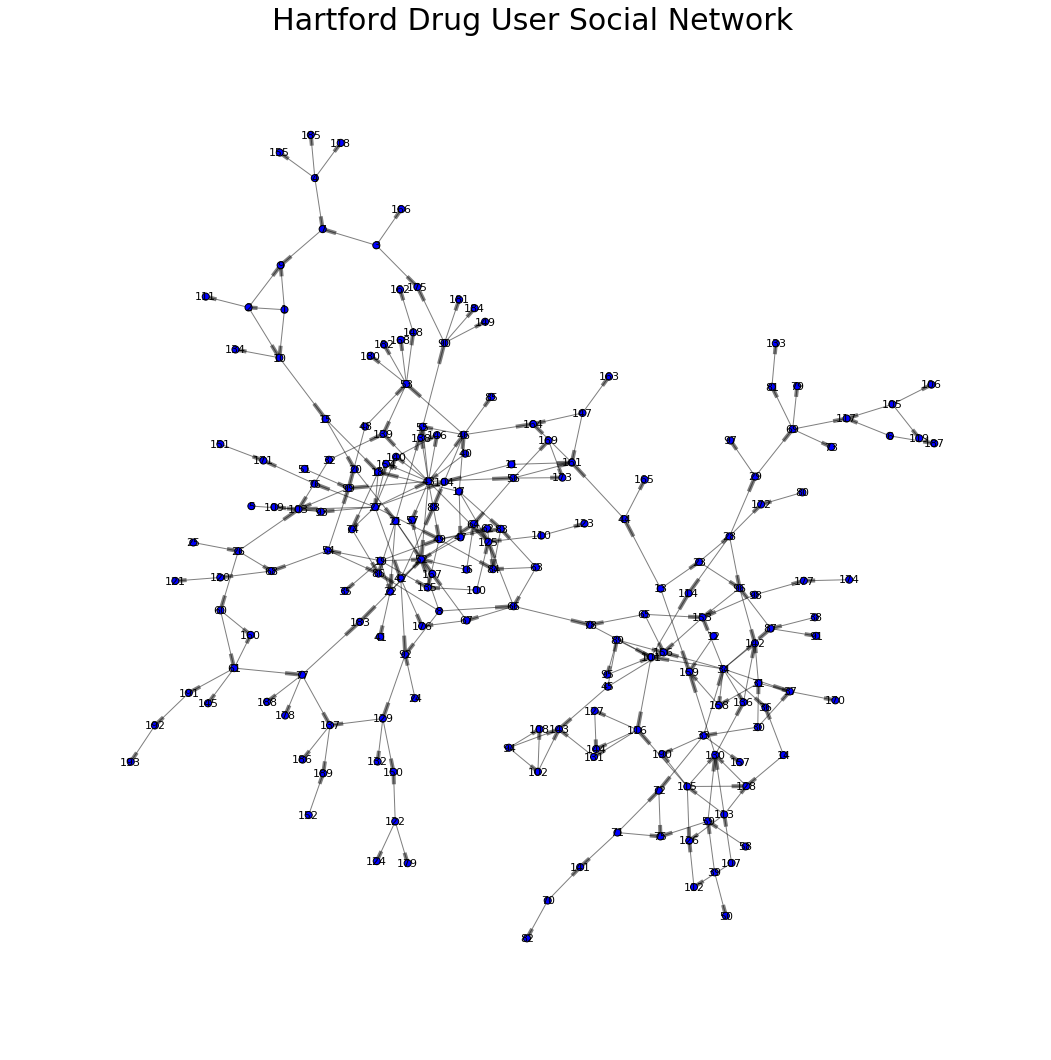

In [12]:
renderNetworkGraph()

In [13]:
dataset[['SOURCE', 'TARGET']].hypergroup(
    createOut = 'never',
    allGraphs = True,
    community = True,
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,273,21,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,193,10,"CASTable('nodes', caslib='CASUSER(kesmit)')"


How many hypergroups and communities do we have?

In [14]:
nodes.distinct()

,Column,NDistinct,NMiss,Trunc
0,_HypGrp_,1.0,0.0,0.0
1,_Value_,193.0,0.0,0.0
2,_Index_,193.0,0.0,0.0
3,_IndexH_,193.0,0.0,0.0
4,_AllXCoord_,193.0,0.0,0.0
5,_AllYCoord_,193.0,0.0,0.0
6,_XCoord_,193.0,0.0,0.0
7,_YCoord_,193.0,0.0,0.0
8,_Color_,4.0,0.0,0.0
9,_Community_,21.0,0.0,0.0


In [15]:
nodes.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,_HypGrp_,0.0,0.0,193.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN
1,_Index_,0.0,192.0,193.0,0.0,96.000000,18528.000000,55.858452,4.020779,3120.166667,2.377760e+06,599072.000000,58.185888,23.875968,2.227736e-59
2,_IndexH_,0.0,192.0,193.0,0.0,96.000000,18528.000000,55.858452,4.020779,3120.166667,2.377760e+06,599072.000000,58.185888,23.875968,2.227736e-59
3,_AllXCoord_,10.0,90.0,193.0,0.0,47.830071,9231.203720,19.150785,1.378504,366.752560,5.119456e+05,70416.491471,40.039215,34.697094,1.209909e-84
4,_AllYCoord_,10.0,90.0,193.0,0.0,47.076530,9085.770251,16.897363,1.216299,285.520890,4.825465e+05,54820.010889,35.893392,38.704740,1.270618e-92
5,_XCoord_,10.0,90.0,193.0,0.0,47.830071,9231.203720,19.150785,1.378504,366.752560,5.119456e+05,70416.491471,40.039215,34.697094,1.209909e-84
6,_YCoord_,10.0,90.0,193.0,0.0,47.076530,9085.770251,16.897363,1.216299,285.520890,4.825465e+05,54820.010889,35.893392,38.704740,1.270618e-92
7,_Color_,0.0,3.0,193.0,0.0,2.098446,405.000000,0.898869,0.064702,0.807966,1.005000e+03,155.129534,42.835014,32.432449,7.842450e-80
8,_Community_,0.0,20.0,193.0,0.0,8.005181,1545.000000,5.721394,0.411835,32.734348,1.865300e+04,6284.994819,71.471134,19.437839,3.113269e-47


### Basic Community Analysis

What are the 5 biggest communities?

In [16]:
topKOut = s.CASTable('topKOut', replace=True)

nodes[['_Community_']].topk(
    aggregator = 'N',
    topK       = 4,
    casOut     = topKOut
)

topKOut = topKOut.sort_values('_Rank_').head(10)
topKOut.columns

Index(['_Column_', '_Fmtvar_', '_Rank_', '_Score_'], dtype='object')

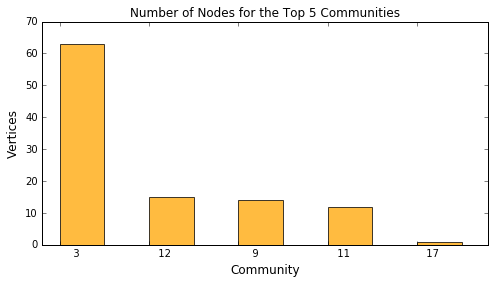

In [17]:
nCommunities = len(topKOut)

ind = np.arange(nCommunities)    # the x locations for the groups

plt.figure(figsize=(8, 4))
p1 = plt.bar(ind + 0.2, topKOut._Score_, 0.5, color='orange', alpha=0.75)

plt.ylabel('Vertices', fontsize=12)
plt.xlabel('Community', fontsize=12)
plt.title('Number of Nodes for the Top %s Communities' % nCommunities)
plt.xticks(ind + 0.2, topKOut._Fmtvar_)

plt.show()

>**Note:** This shows that the biggest communities have up to 63 vertices.

What nodes belong to community 4?

In [18]:
nodes.query('_Community_ EQ 4').head()

,_HypGrp_,_Value_,_Index_2,_IndexH_,_AllXCoord_,_AllYCoord_,_XCoord_,_YCoord_,_Color_,_Community_
0,0.0,129,33.0,18.0,35.096364,31.878018,35.096364,31.878018,1.0,4.0
1,0.0,132,37.0,159.0,34.580579,27.601399,34.580579,27.601399,3.0,4.0
2,0.0,150,57.0,19.0,36.158100,26.573935,36.158100,26.573935,3.0,4.0
3,0.0,24,110.0,161.0,38.304212,33.911096,38.304212,33.911096,3.0,4.0
4,0.0,92,185.0,17.0,37.327424,38.244730,37.327424,38.244730,1.0,4.0


What edges do we have?

In [19]:
edges.head()

,_HypGrp_,_Source_,_Target_,_Sindex_,_Tindex_,_SindexH_,_TindexH_,_AllSourceX_,_AllSourceY_,_AllTargetX_,...,_SourceX_,_SourceY_,_TargetX_,_TargetY_,_SColor_,_TColor_,_SCommunity_,_TCommunity_,FROM,TO
0,0.0,4,155,127.0,62.0,3.0,5.0,28.327871,85.695405,24.832819,...,28.327871,85.695405,24.832819,88.236098,3.0,3.0,1.0,1.0,4.0,155.0
1,0.0,4,185,127.0,95.0,3.0,4.0,28.327871,85.695405,27.930495,...,28.327871,85.695405,27.930495,90.000000,3.0,3.0,1.0,1.0,4.0,185.0
2,0.0,5,103,138.0,5.0,155.0,154.0,22.008460,53.038377,26.708770,...,22.008460,53.038377,26.708770,52.722169,3.0,1.0,3.0,3.0,5.0,103.0
3,0.0,6,117,149.0,20.0,126.0,125.0,85.580720,60.028691,81.272205,...,85.580720,60.028691,81.272205,61.758830,3.0,3.0,18.0,18.0,6.0,117.0
4,0.0,6,187,149.0,97.0,126.0,127.0,85.580720,60.028691,90.000000,...,85.580720,60.028691,90.000000,59.279773,3.0,3.0,18.0,18.0,6.0,187.0


### Render the network graph

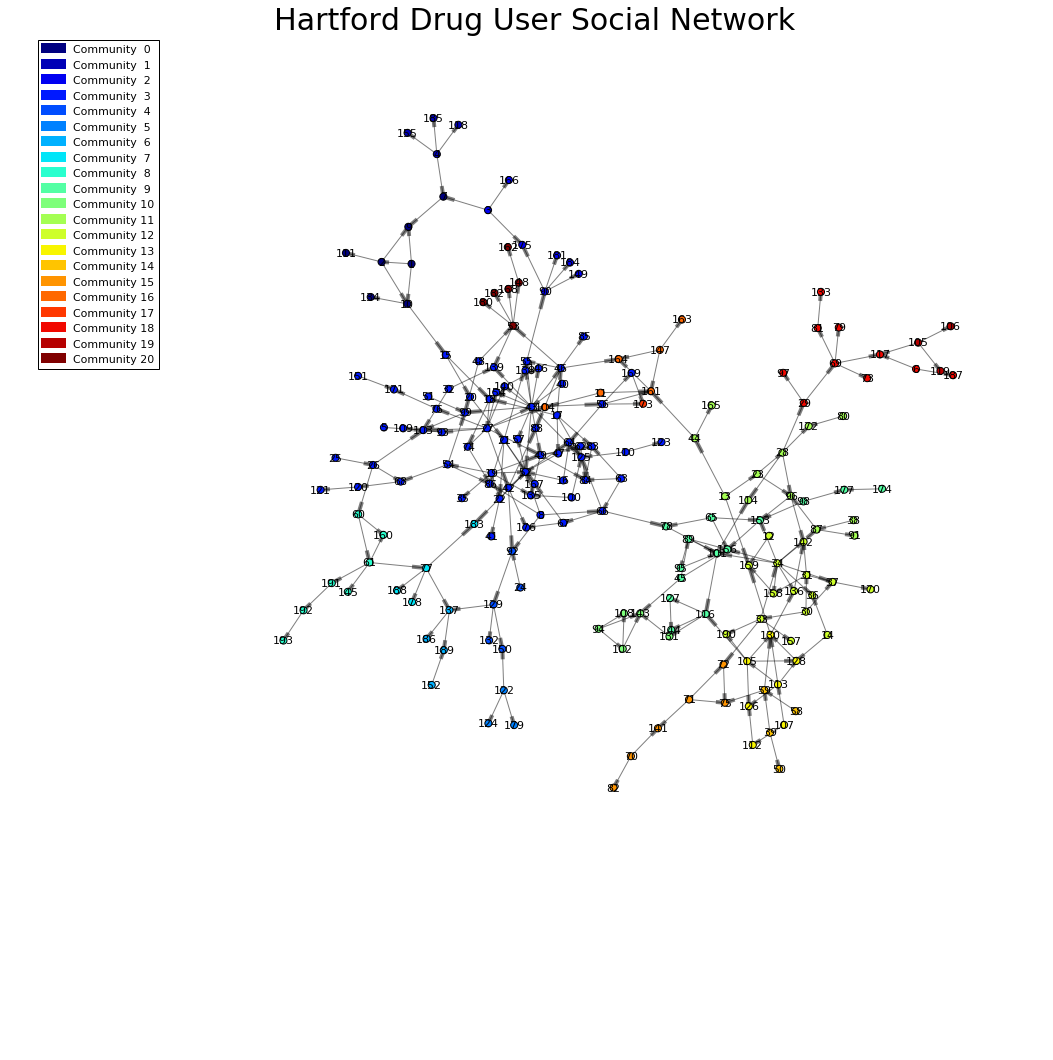

In [20]:
renderNetworkGraph(colorVar='_Community_')

### Reduce Number of Communities

Limit the communities to 5.

In [21]:
dataset[['SOURCE', 'TARGET']].hypergroup(
    createOut = 'never',
    community = True,
    nCommunities = 5,
    allGraphs = True,
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,273,21,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,193,10,"CASTable('nodes', caslib='CASUSER(kesmit)')"


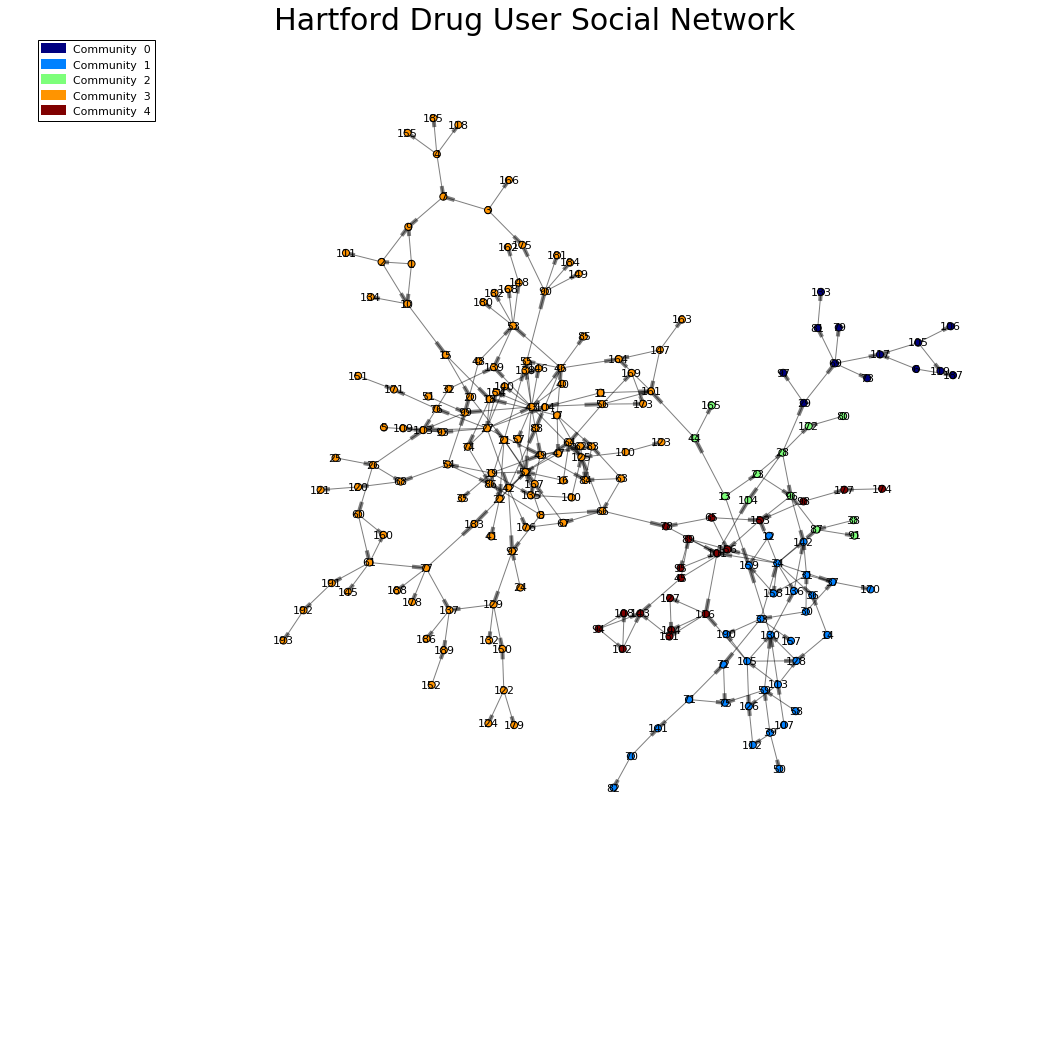

In [22]:
renderNetworkGraph(colorVar='_Community_')

### Analyze Node Centrality

How important is a user in the network?

In [23]:
dataset[['SOURCE', 'TARGET']].hypergroup(
    createOut = 'never',
    community = True,
    nCommunities = 5,
    centrality = True,
    mergeCommSmallest = True,
    allGraphs = True,
    graphPartition = True,
    scaleCentralities = 'central1', # returns centrality values closer to 1 in the center
    edges     = edges,
    vertices  = nodes
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),edges,273,33,"CASTable('edges', caslib='CASUSER(kesmit)')"
1,CASUSER(kesmit),nodes,193,16,"CASTable('nodes', caslib='CASUSER(kesmit)')"


In [24]:
nodes.head()

,_HypGrp_,_Value_,_Index_2,_IndexH_,_AllXCoord_,_AllYCoord_,_XCoord_,_YCoord_,_Color_,_Community_,_Reach_,_Stress_,_Closeness_,_Betweenness_,_CentroidMag_,_CentroidAngle_
0,0.0,1,0.0,0.0,25.304981,72.590769,25.304981,72.590769,1.0,3.0,15.0,0.705830,0.485646,0.621396,34.034631,318.504882
1,0.0,10,1.0,191.0,24.797382,67.806432,24.797382,67.806432,1.0,3.0,14.0,0.776207,0.618820,0.719961,30.987637,312.035207
2,0.0,100,2.0,147.0,44.434348,44.670380,44.434348,44.670380,1.0,3.0,11.0,0.897821,0.843700,0.886595,4.161789,234.546485
3,0.0,101,3.0,57.0,61.800675,38.001637,61.800675,38.001637,2.0,2.0,11.0,0.951119,0.923445,0.937491,16.659275,123.157377
4,0.0,102,4.0,134.0,50.538193,26.589394,50.538193,26.589394,2.0,2.0,15.0,0.349234,0.400319,0.415087,20.665349,172.625495


Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path(s) 
between two other nodes.  As such it describes the importance of a node in a network.

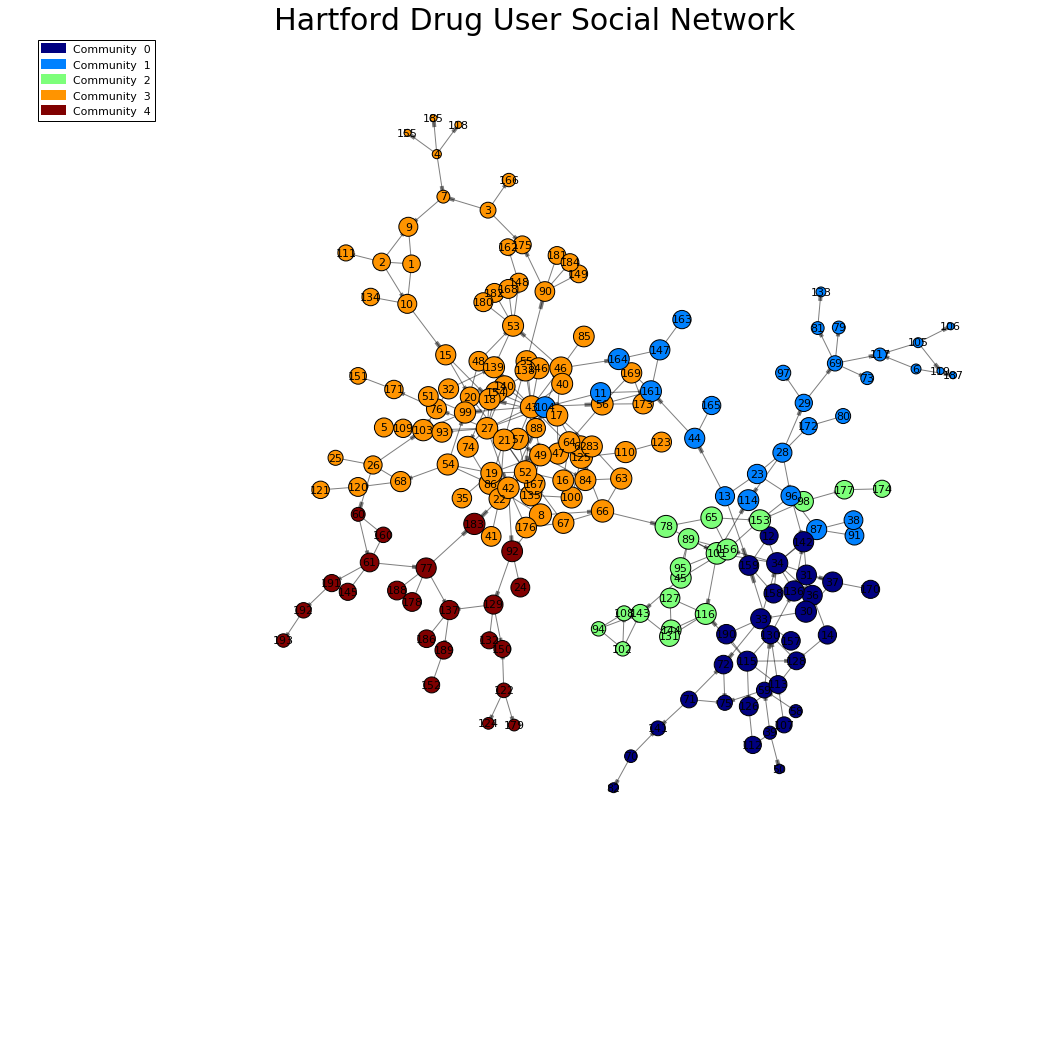

In [25]:
renderNetworkGraph(colorVar='_Community_', sizeVar='_Betweenness_')

### Filter Communities

Only filter community 2.

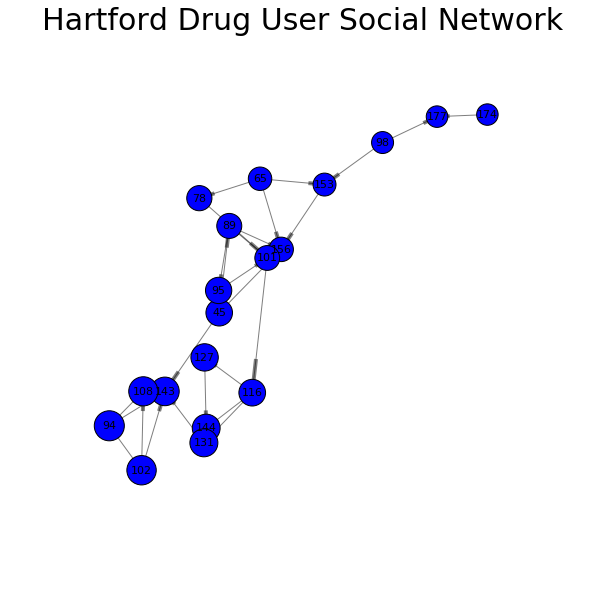

In [26]:
renderNetworkGraph(2, size=10, sizeVar='_CentroidAngle_', sizeMultipler=5)

In [27]:
s.close()

>Falko Schulz ▪ Principal Software Developer ▪ Business Intelligence Visualization R&D ▪ SAS® Institute ▪ [falko.schulz@sas.com](mailto:falko.schulz@sas.com) ▪ http://www.sas.com

>Data used by permission from Margaret R. Weeks at the Institute of Community Resesarch (http://www.incommunityresearch.org) https://www.researchgate.net/publication/227085871_Social_Networks_of_Drug_Users_in_High-Risk_Sites_Finding_the_Connections 